## Working with Keras: A deep dive
- Creating Keras models with the Sequential class, The Functional API, and Model subclassing
- Using built-in Keras training and evaluation loops
- Using Keras callbacks to customize training
- Writing training and evaluation loops from scratch

## Different ways to build Keras models
- The Sequential model: the mos approachable API - it's bassically a Python list. As such, it's limited to simples stacks of layers
- The Functional API, which focuses on graph-like model architectures, It represents a nice mid-point between usability and flexibility, and as such, it's the most commonly used model-building API
- Model subclassing, a low-level option where you write everything yourself from scratch. This is ideal if you want full control over every little thing. However, you won't get acess to many built-in Keras featuresm and you will be more at risk of making mistakes

### The Sequential model

The Sequential model ia easy to use, but its applicability is extremely limited: it can only express models with a single input and a single output, applying one layer after the other in a sequential fashion. In practice, it's pretty common to enconter models with multiple inputs (say, an image and its metadata), multiple outputs (different things you want to predict about the data), or a nonlinear topology.

In [1]:
# Listing 7.1 The Sequential class

from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])

It's possible to build the same model incrementally via the add() method, which is similar to the append() metlhod of a Python list.

In [2]:
# Listing 7.2 Incrementally building a Sequential model

model = keras.Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

These models don't have any weights until you actually call it on some data, or call its build() method with an input shape.

In [3]:
# Listing 7.4 Calling a model for the first time to build it

model.build(input_shape=(None, 3)) # Builds the model - now the model will expect samples of shape (3,). The None in the input shape signals that the batch size could be anything.

model.weights # Now you can retrive the model's weights.

[<tf.Variable 'dense_2/kernel:0' shape=(3, 64) dtype=float32, numpy=
 array([[-0.24028073, -0.19180472,  0.01998734, -0.01571992,  0.21401799,
          0.16785938, -0.11127003,  0.22531694,  0.01965436, -0.02733085,
          0.01044554,  0.23341012,  0.06874532, -0.27218565,  0.09478998,
          0.15401405,  0.22255874,  0.01652679,  0.18178904, -0.21704523,
         -0.14470093,  0.07203656, -0.21826828,  0.13749334, -0.17735457,
          0.29584205,  0.22240222, -0.08163166, -0.24185023,  0.04814547,
          0.22356838,  0.19927394, -0.2364105 ,  0.27611214, -0.01224458,
         -0.05103552,  0.28401184, -0.13310918,  0.26933676,  0.01788831,
          0.01862338,  0.02363896, -0.09514301,  0.27258718, -0.16892923,
          0.03664634,  0.03293455,  0.13872972, -0.08475403, -0.1482728 ,
          0.03446168, -0.26869762,  0.02346909, -0.06182969, -0.10775924,
          0.0816614 , -0.00682646, -0.26634103, -0.06528811, -0.06672561,
         -0.02851021, -0.26127064, -0.27181

After the model is built, you van display its contents via the summary(), which comes in handy for debugging.

In [4]:
# Listing 7.5 the summary() method

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 906 (3.54 KB)
Trainable params: 906 (3.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


You can give names to everything in Keras-every model, every layer

In [5]:
# Listing 7.6 Naming models and layers with the name argument

model = keras.Sequential(name="my_example_model")
model.add(layers.Dense(64, activation="relu", name="my_first_layer"))
model.add(layers.Dense(10, activation="softmax", name="my_last_layer"))
model.build((None, 3))
model.summary()

Model: "my_example_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_first_layer (Dense)      (None, 64)                256       
                                                                 
 my_last_layer (Dense)       (None, 10)                650       
                                                                 
Total params: 906 (3.54 KB)
Trainable params: 906 (3.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


You can't print a summary until the model is built! There's actually a way to have your Sequential built on the fly: just declare the shape of the model's inputs in advance. You can do this via the Input class

In [6]:
# Listing 7,7 Specifying the input shape of your model in advance

model = keras.Sequential(name="second_example")
model.add(keras.Input(shape=(3,))) # Use Input to declare the shape of the inputs. Note that the shape argument must be the shape of each sample, not the shape of one batch.
model.add(layers.Dense(64, activation="relu"))
model.summary()

Model: "second_example"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                256       
                                                                 
Total params: 256 (1.00 KB)
Trainable params: 256 (1.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now we can use summary() to follow how the output shape of your model changes as you add more layers

In [7]:
model. add(layers.Dense(10, activation="softmax"))
model.summary()

Model: "second_example"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                256       
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 906 (3.54 KB)
Trainable params: 906 (3.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### The functional API

This is what most Keras models you'll encounter in the wild use.

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
inputs = keras.Input(shape=(3,), name="my_input") # The inputs object holds information about the shape and dtype of the data that the model will process
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_6 (Dense)             (None, 64)                256       
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 906 (3.54 KB)
Trainable params: 906 (3.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
print(f"inputs.shape: {inputs.shape}") # The model will process batches where each sample has shape (3,). The number of samples per batch is variable (indicated by the None batch size).
print(f"inputs.dtype: {inputs.dtype}") # These batchs will have dtype float 32
print(f"\nfeatures.shape: {features.shape}")

inputs.shape: (None, 3)
inputs.dtype: <dtype: 'float32'>

features.shape: (None, 64)


#### Multi-input, Multi-output models

They may, for instace, have multiple inputs or multiple outputs. It's for this kind of model that the Functional API really shines.

Example:
Let's say you're building a system to rank customer supprt tickets by priority and route them to the appropriate deparment. Your model has three inputs:
- The title of the ticket (text input)
- The text body of the ticket (text input)
- Any tags added by the user (categorical inputm assumed here to be one-hot encoded)

Your model also has two outputs:
- The priority score of the ticket, a scalar between 0 and 1 (sigmoid output)
- The department that should handle the ticket (a softmax over the set of departments)


In [11]:
# Listing 7.9 A multi-input, multi-output Functional model

vocabularySize = 10000
numTags = 100
numDepartaments = 4

# Define model inputs
title = keras.Input(shape=(vocabularySize, ), name="title")
textBody = keras.Input(shape=(vocabularySize, ), name="textBody")
tags = keras.Input(shape=(numTags, ), name="tags")

features = layers.Concatenate()([title, textBody, tags]) # Combine input features into a single tensor, features, by concatenating them
features = layers.Dense(64, activation="relu")(features) 

priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(
    numDepartaments, activation="softmax", name="departament"
)(features)

model = keras.Model(inputs=[title, textBody, tags], outputs=[priority, department]) # Apply an intermediate  layer to recombine input features into richer representations.

model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 title (InputLayer)          [(None, 10000)]              0         []                            
                                                                                                  
 textBody (InputLayer)       [(None, 10000)]              0         []                            
                                                                                                  
 tags (InputLayer)           [(None, 100)]                0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 20100)                0         ['title[0][0]',               
                                                                     'textBody[0][0]',      

In [12]:
# Listing 7.10 Training a model by providing lists of input and target arrays

import numpy as np

numSamples = 1280

titleData = np.random.randint(0, 2, size=(numSamples, vocabularySize))
textBodyData = np.random.randint(0, 2, size=(numSamples, vocabularySize))
tagsData = np.random.randint(0, 2, size=(numSamples, numTags))

priorityData = np.random.random(size=(numSamples, 1))
departmentData = np.random.randint(0, 2, size=(numSamples, numDepartaments))

model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]]
              )

model.fit([titleData, textBodyData, tagsData],
          [priorityData, departmentData],
          epochs=1)

model.evaluate([titleData, textBodyData, tagsData],
               [priorityData, departmentData])

priorityPreds, departamentPreds = model.predict([titleData, textBodyData, tagsData])

40/40 [==============================] - 0s 4ms/step


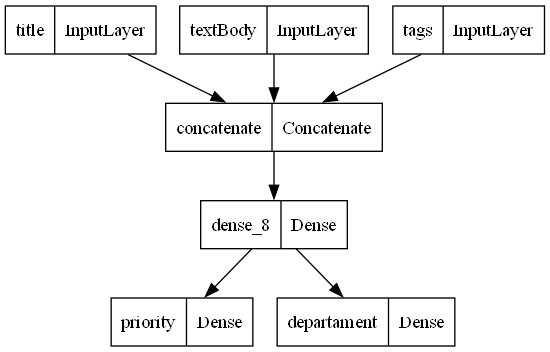

In [13]:
keras.utils.plot_model(model, "ticket_classifier.png")

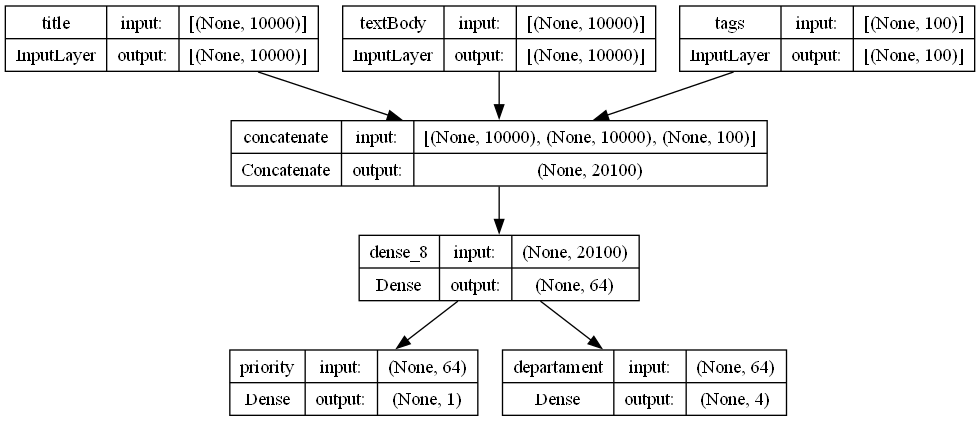

In [14]:
keras.utils.plot_model(model, "ticketClassifierWithShapeInfo.png", show_shapes=True)

In [16]:
print(model.layers)
print("\n", model.layers[3].input)
print("\n", model.layers[3].output)

[<keras.src.engine.input_layer.InputLayer object at 0x0000016680B73580>, <keras.src.engine.input_layer.InputLayer object at 0x0000016680B735E0>, <keras.src.engine.input_layer.InputLayer object at 0x0000016680B73E50>, <keras.src.layers.merging.concatenate.Concatenate object at 0x0000016680A72040>, <keras.src.layers.core.dense.Dense object at 0x0000016680B8AA30>, <keras.src.layers.core.dense.Dense object at 0x0000016680AFC850>, <keras.src.layers.core.dense.Dense object at 0x0000016680B997F0>]

 [<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>, <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'textBody')>, <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

 KerasTensor(type_spec=TensorSpec(shape=(None, 20100), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


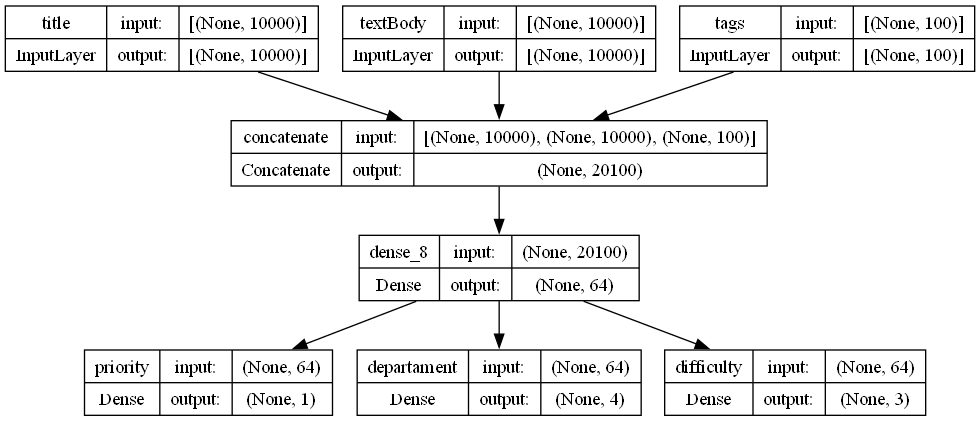

In [18]:
# Listing 7.13 Creating a new model by reusing intermediate layer outputs

features = model.layers[4].output # layers[4] is our intermediate Dense layer

difficult = layers.Dense(3, activation="softmax", name="difficulty")(features)

newModel = keras.Model(
    inputs=[title, textBody, tags],
    outputs=[priority, department, difficult]
)

keras.utils.plot_model(newModel, "updated_ticket_classifier.png", show_shapes=True)

### Subclassing the Model class

We can create custom layers with Subclassing Model.

In [19]:
# Listing 7.14 A simple subclassed model

class CustomerTicketModel(keras.Model):

    def __init__(self, numDepartaments):
        super().__init__()
        self.concatLayer = layers.Concatenate()
        self.mixingLayer = layers.Dense(64, activation="relu")
        self.priorityScorer = layers.Dense(1, activation="sigmoid")
        self.departmentClassifier = layers.Dense(numDepartaments, activation="softmax")

    def call(self, inputs):
        title = inputs["title"]
        textBody = inputs["textBody"]
        tags = inputs["tags"]

        features = self.concatLayer([title, textBody, tags])
        features = self.mixingLayer(features)
        priority = self.priorityScorer(features)
        department = self.departmentClassifier(features)
        return priority, department

In [20]:
model = CustomerTicketModel(numDepartaments=4)

priority, department = model(
    {"title": titleData, "textBody": textBodyData, "tags": tagsData}
)